# Satija lab Seurat guided clustering tutorial

In [35]:
install.packages("Seurat", dependencies = TRUE)
install.packages('BiocManager')
BiocManager::install('limma')

Warning message:
“dependencies ‘SingleCellExperiment’, ‘MAST’, ‘DESeq2’, ‘monocle’, ‘limma’, ‘multtest’ are not available”
also installing the dependencies ‘mutoss’, ‘qqconf’, ‘Cairo’, ‘hdf5r’, ‘metap’, ‘ggrastr’


Warning message in install.packages("Seurat", dependencies = TRUE):
“installation of package ‘mutoss’ had non-zero exit status”
Warning message in install.packages("Seurat", dependencies = TRUE):
“installation of package ‘qqconf’ had non-zero exit status”
Warning message in install.packages("Seurat", dependencies = TRUE):
“installation of package ‘Cairo’ had non-zero exit status”
Warning message in install.packages("Seurat", dependencies = TRUE):
“installation of package ‘hdf5r’ had non-zero exit status”
Warning message in install.packages("Seurat", dependencies = TRUE):
“installation of package ‘metap’ had non-zero exit status”
Warning message in install.packages("Seurat", dependencies = TRUE):
“installation of package ‘ggrastr’ had non-zero exit status”
Updating HTML index

In [22]:
library(dplyr)
library(Seurat)
library(patchwork)

In [3]:
# Step 1: setup Seurat object
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "../pbmc3k_filtered_gene_bc_matrices/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [4]:
# Lets examine a few genes in the first thirty cells
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]

# The . values in the matrix represent 0s (no molecules detected). Most values in an scRNA-seq matrix are 0

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

In [5]:
dense.size <- object.size(as.matrix(pbmc.data))
dense.size

709591472 bytes

In [6]:
sparse.size <- object.size(pbmc.data)
sparse.size

29905192 bytes

In [7]:
dense.size/sparse.size

23.7 bytes

In [8]:
# Step 2: pre-processing
# common QC metrics include...
# - the number of unique genes detected in each cell (low-quality cells or empty droplets will often have very few genes, cell doublets or multiplets may exhibit an aberrantly high gene count)
# - the total number of molecules detected within a cell (correlates strongly with unique genes)
# - the percentage of reads that map to the mitochondrial genome (low-quality/dying cells often exhibit extensive mitochondrial contamination, calculate mitochondrial QC metrics with the PercentageFeatureSet() function, which calculates the percentage of counts originating from a set of features, use the set of all genes starting with MT- as a set of mitochondrial genes)

# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [9]:
# The number of unique genes and total molecules are automatically calculated during CreateSeuratObject()
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


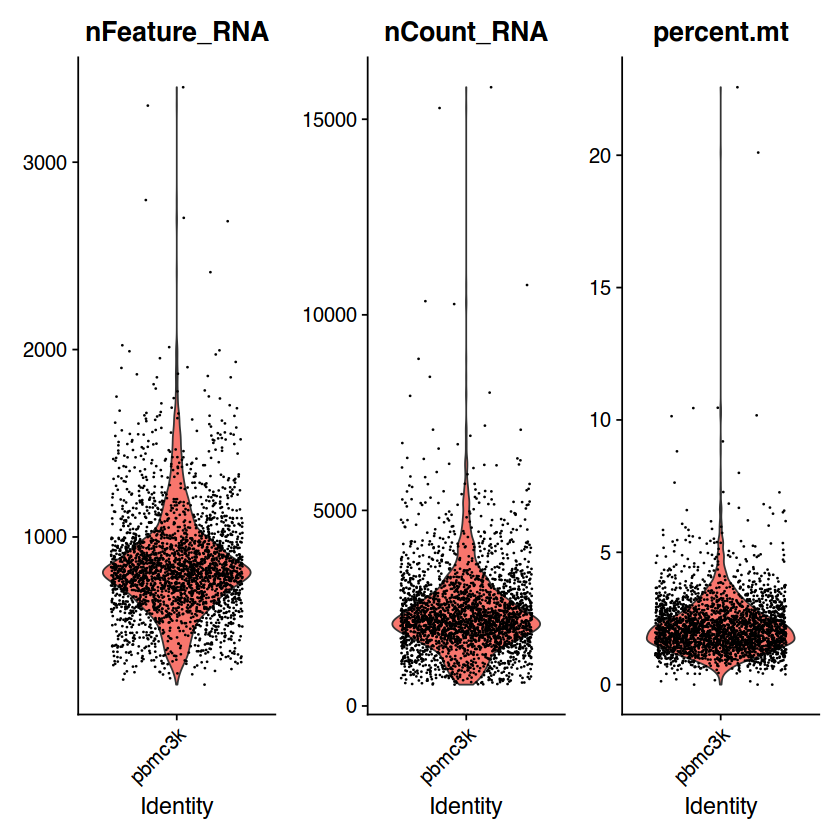

In [10]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

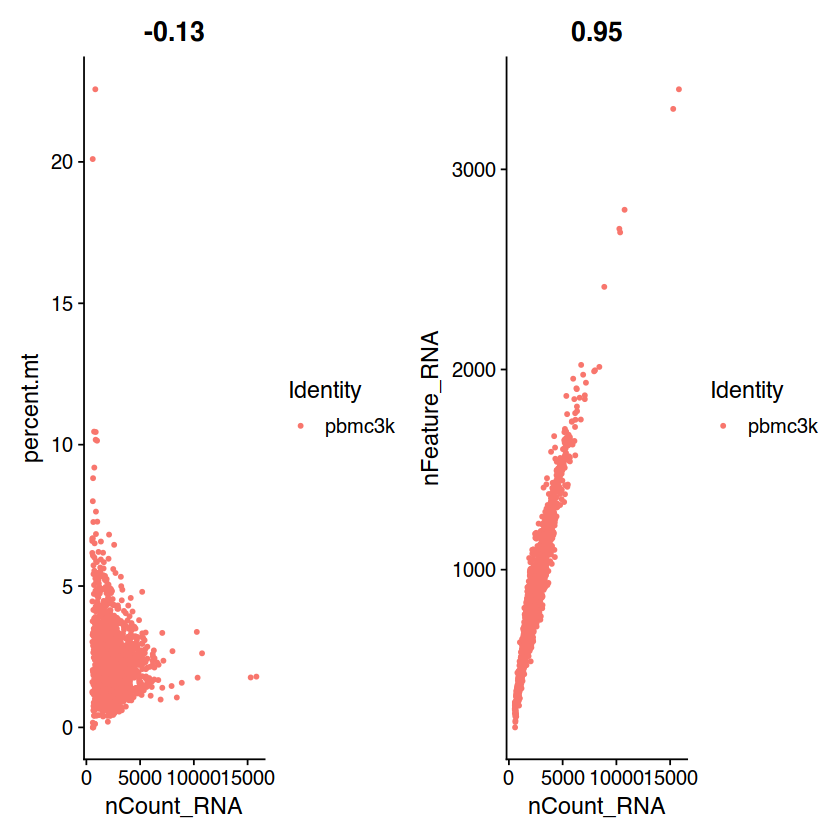

In [11]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

In [12]:
# we filter cells that have unique feature counts over 2,500 or less than 200
# we filter cells that have >5% mitochondrial counts
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [13]:
# Step 3: normalize data
# after removing unwanted cells from the dataset, the next step is to normalize the data
# By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result
# Normalized values are stored in pbmc[["RNA"]]@data.
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
# pbmc <- NormalizeData(pbmc) does the same thing as we use default arguments here

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


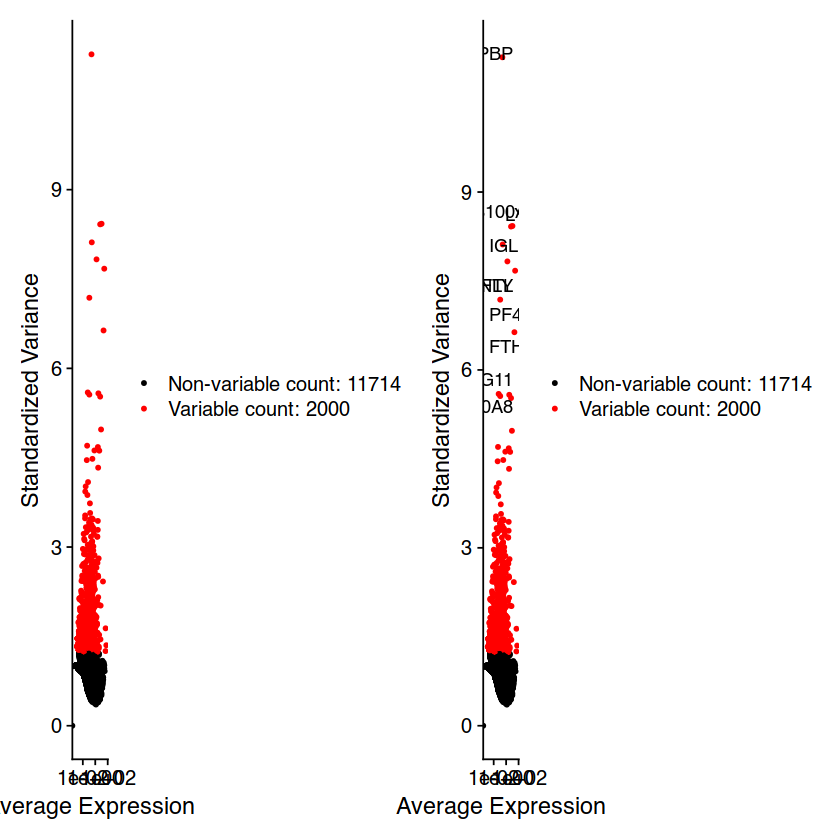

In [14]:
# Step 4: identification of highly variable features (feature selection)

# We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others)

# directly model the mean-variance relationship inherent in single-cell data, implemented in the FindVariableFeatures() function. By default, we return 2,000 features per dataset. These will be used in downstream analysis, like PCA.

pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
plot1 + plot2

In [15]:
# Step 5: scale the data
# apply a linear transformation (‘scaling’) that is a standard pre-processing step prior to dimensional reduction techniques like PCA
# The ScaleData() function shifts the expression of each gene, so that the mean expression across cells is 0, scales the expression of each gene, so that the variance across cells is 1
# This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
# The results of this are stored in pbmc[["RNA"]]@scale.data

all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [16]:
# Step 6: Perform linear dimensional reduction
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

In [17]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


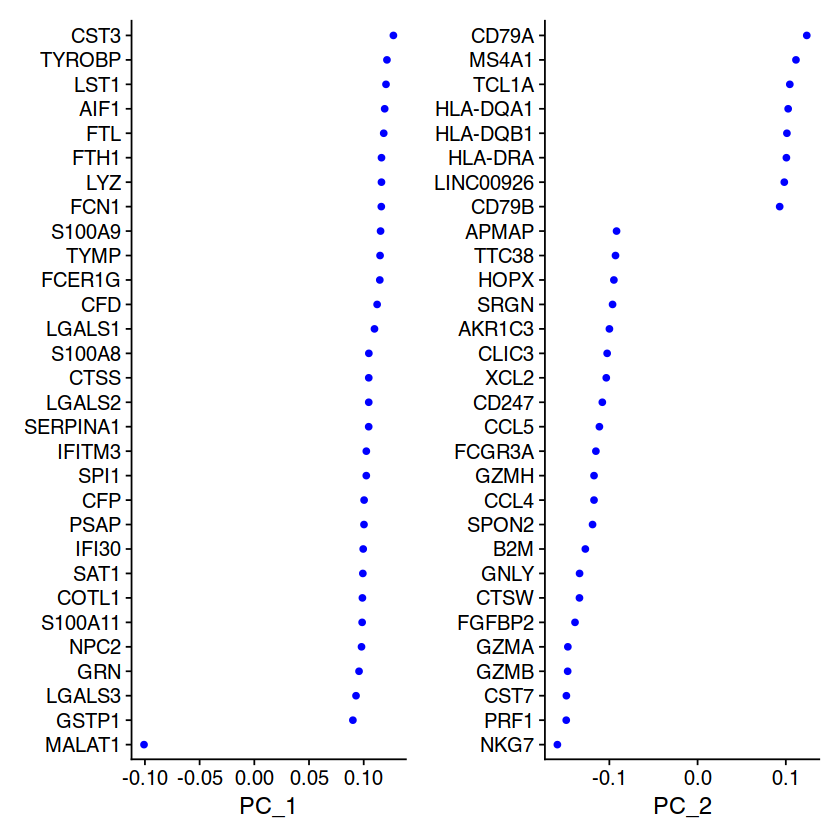

In [18]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

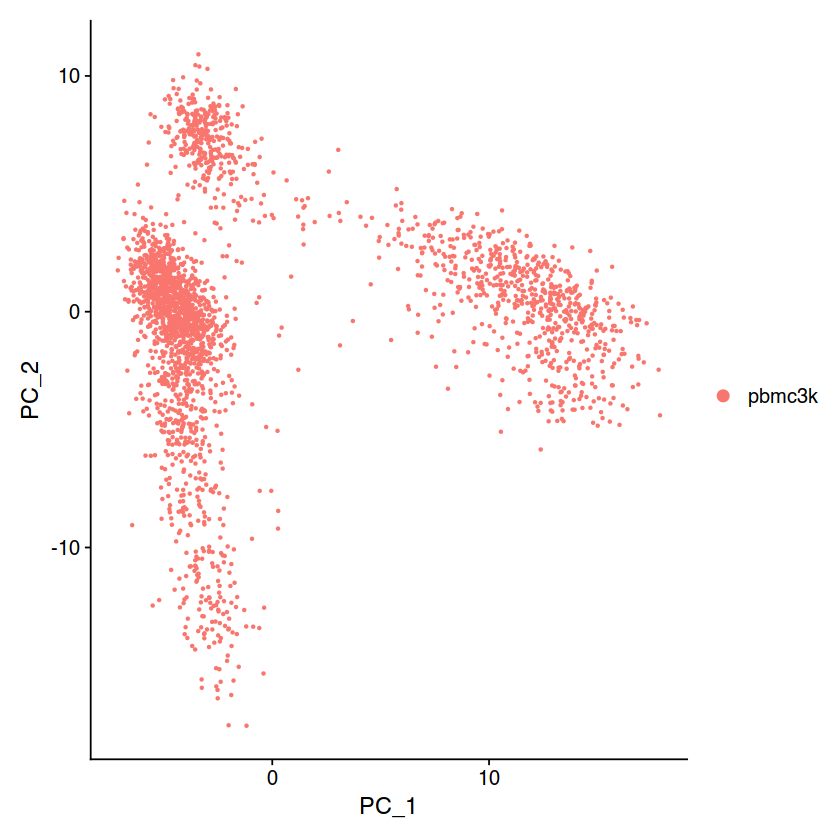

In [19]:
DimPlot(pbmc, reduction = "pca")

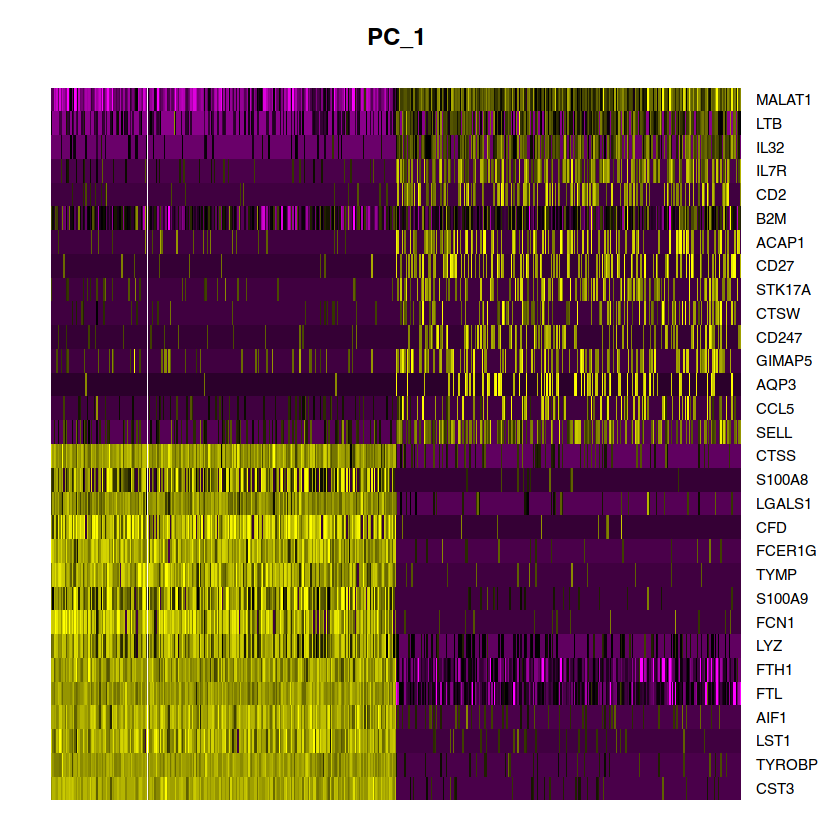

In [20]:
# DimHeatmap() allows for easy exploration of the primary sources of heterogeneity in a dataset and can be useful when trying to decide which PCs to include for further downstream analyses
# Both cells and features are ordered according to their PCA scores
# Setting cells to a number plots the ‘extreme’ cells on both ends of the spectrum, which dramatically speeds plotting for large datasets

DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

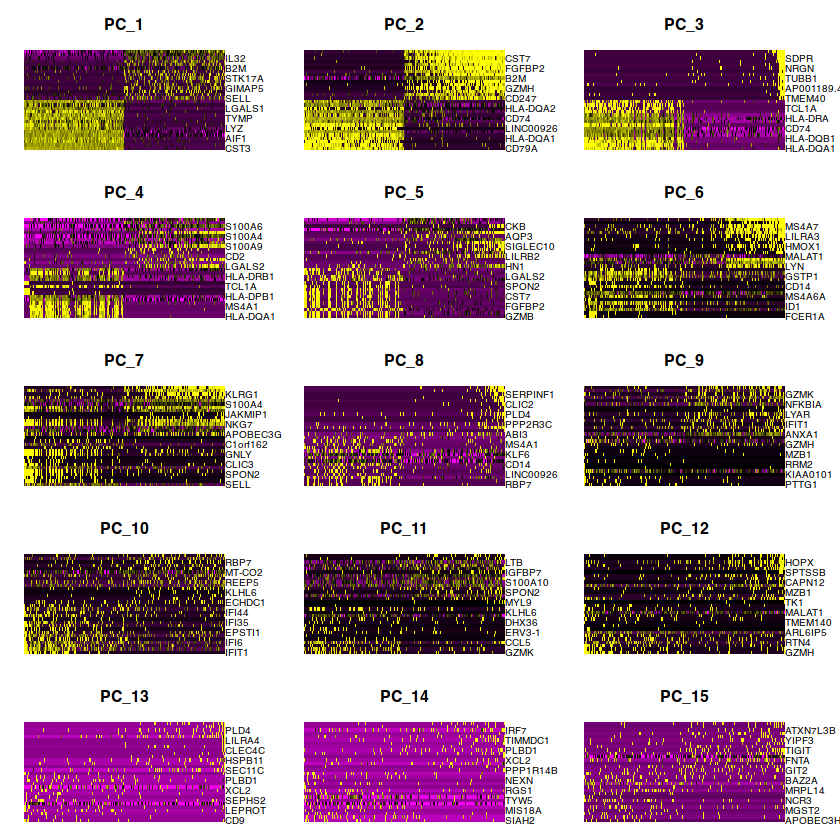

In [21]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

In [23]:
# Step 7: Determine the ‘dimensionality’ of the dataset
# To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a ‘metafeature’ that combines information across a correlated feature set
# The top principal components therefore represent a robust compression of the dataset
# However, how many components should we choose to include? 10? 20? 100?

# We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a ‘null distribution’ of feature scores, and repeat this procedure
# We identify ‘significant’ PCs as those who have a strong enrichment of low p-value features.

pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23516 rows containing missing values (`geom_point()`).”


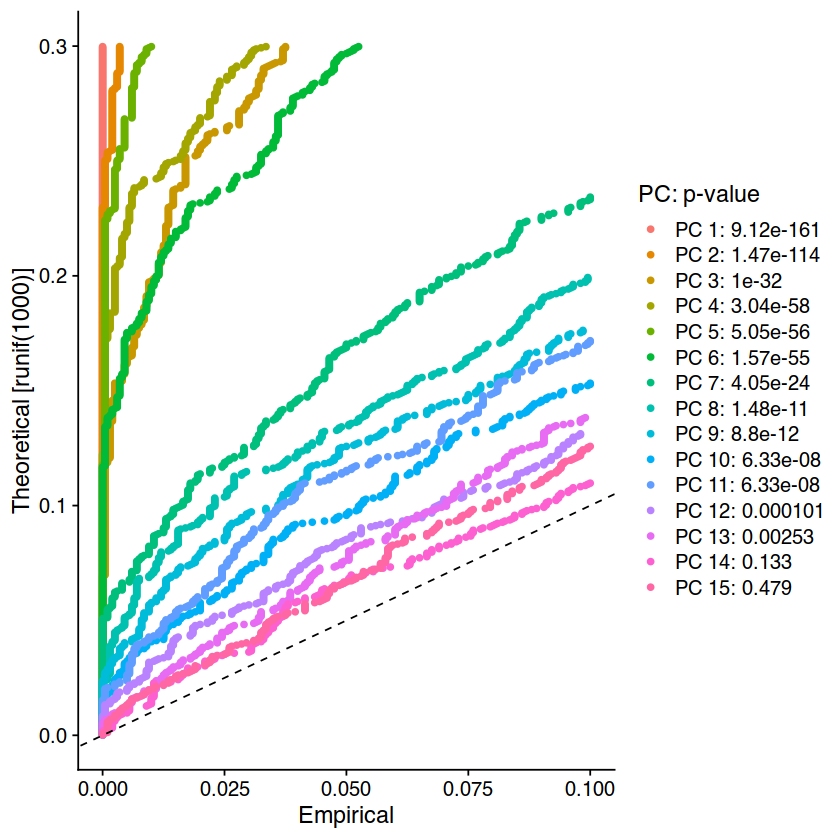

In [24]:
# The JackStrawPlot() function provides a visualization tool for comparing the distribution of p-values for each PC with a uniform distribution (dashed line)
# ‘Significant’ PCs will show a strong enrichment of features with low p-values (solid curve above the dashed line)
# In this case it appears that there is a sharp drop-off in significance after the first 10-12 PCs.

JackStrawPlot(pbmc, dims = 1:15)

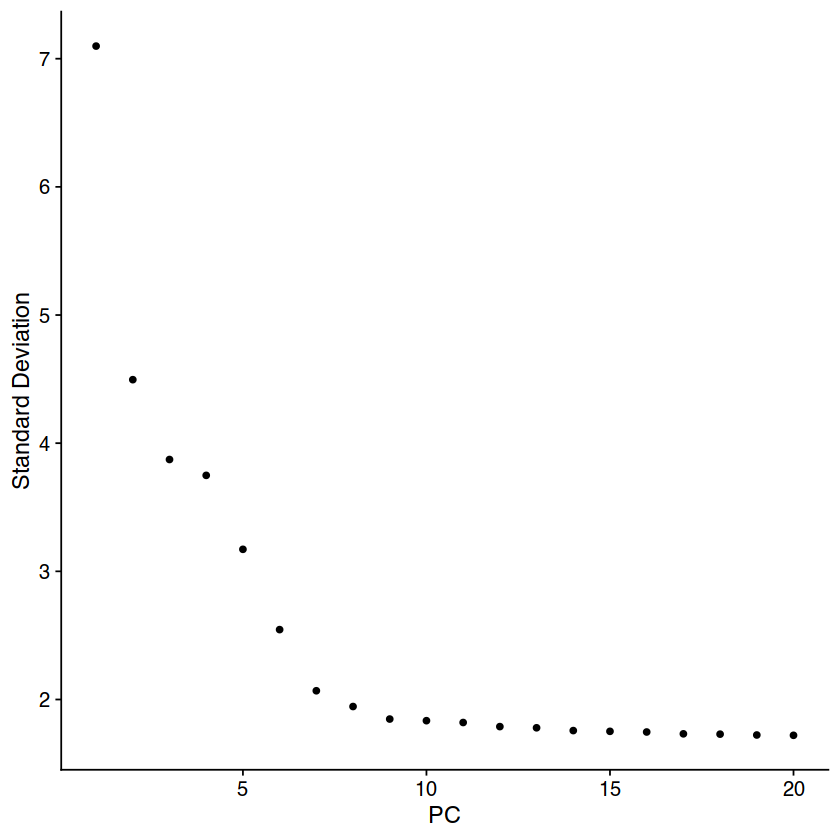

In [25]:
# An alternative heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot() function)
# In this example, we can observe an ‘elbow’ around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs.

ElbowPlot(pbmc)

# it's encouraged to repeat downstream analyses with a different number of PCs (10, 15, or even 50!); the results often do not differ dramatically.
# it's advised to err on the higher side when choosing this parameter; For example, performing downstream analyses with only 5 PCs does significantly and adversely affect results.

In [26]:
# Step 8: cluster the cells

# graph-based clustering approach
# distance metric drives the clustering analysis (based on previously identified PCs)
# embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected ‘quasi-cliques’ or ‘communities’.
# first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity)
# This step is performed using the FindNeighbors() function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).

# To cluster the cells, we next apply modularity optimization techniques such as the Louvain algorithm (default) or SLM to iteratively group cells together, with the goal of optimizing the standard modularity function
# The FindClusters() function implements this procedure and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters
# We find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells
# Optimal resolution often increases for larger datasets
# The clusters can be found using the Idents() function.

pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [27]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

In [28]:
# Step 9: Run non-linear dimensional reduction (UMAP/tSNE)

# non-linear dimensional reduction techniques, such as tSNE and UMAP, visualize and explore these datasets
# The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space
# Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots
# As input to the UMAP and tSNE, use the same PCs as input to the clustering analysis

pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:47:17 UMAP embedding parameters a = 0.9922 b = 1.112

20:47:17 Read 2638 rows and found 10 numeric columns

20:47:17 Using Annoy for neighbor search, n_neighbors = 30

20:47:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:47:18 Writing NN index file to temp file /tmp/Rtmprf8147/file2c924f210a0

20:47:18 Searching Annoy index using 1 thread, search_k = 3000

20:47:19 Annoy recall = 100%

20:47:19 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

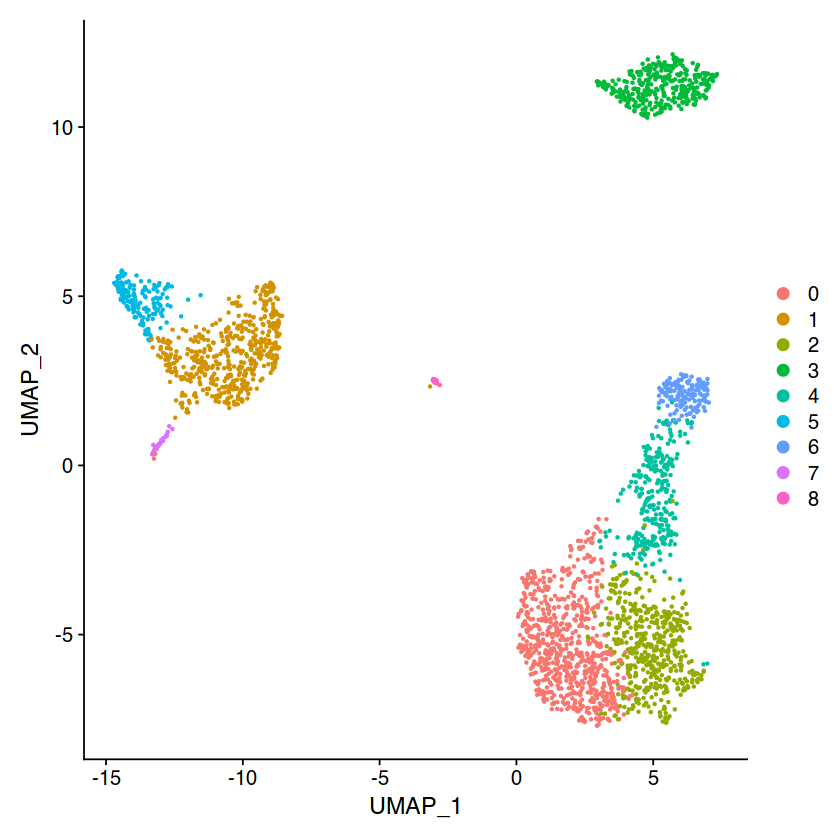

In [31]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label individual clusters
DimPlot(pbmc, reduction = "umap")

In [33]:
# You can save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above, or easily shared with collaborators.
saveRDS(pbmc, file = "../output/pbmc_tutorial.rds")

In [36]:
# Step 10: Finding differentially expressed features (cluster biomarkers)

# find markers that define clusters via differential expression
# By default, it identifies positive and negative markers of a single cluster (specified in ident.1), compared to all other cells
# FindAllMarkers() automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

# The min.pct argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups
# You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory
# As another option to speed up these computations, max.cells.per.ident can be set
# This will downsample each identity class to have no more cells than whatever this is set to
# While there is generally going to be a loss in power, the speed increases can be significant and the most highly differentially expressed features will likely still rise to the top.

# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,2.593535e-91,1.2154360,0.949,0.466,3.556774e-87
LTB,7.994465e-87,1.2828597,0.981,0.644,1.096361e-82
CD3D,3.922451e-70,0.9359210,0.922,0.433,5.379250e-66
IL7R,1.130870e-66,1.1776027,0.748,0.327,1.550876e-62
LDHB,4.082189e-65,0.8837324,0.953,0.614,5.598314e-61


In [37]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,2.150929e-209,4.267579,0.975,0.039,2.949784e-205
IFITM3,6.103366e-199,3.877105,0.975,0.048,8.370156e-195
CFD,8.891428e-198,3.411039,0.938,0.037,1.219370e-193
CD68,2.374425e-194,3.014535,0.926,0.035,3.256286e-190
RP11-290F20.3,9.308287e-191,2.722684,0.840,0.016,1.276538e-186


In [38]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.167632e-83,1.333503,0.435,0.108,1.601290e-79,0,CCR7
1.740957e-109,1.069166,0.897,0.593,2.387549e-105,0,LDHB
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,1,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,1,S100A8
7.994465e-87,1.282860,0.981,0.644,1.096361e-82,2,LTB
2.610017e-59,1.240361,0.424,0.111,3.579377e-55,2,AQP3
0.000000e+00,4.310172,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,3.591579,0.622,0.022,1.300332e-266,3,TCL1A
4.932509e-169,3.006739,0.595,0.056,6.764443e-165,4,GZMK


In [39]:
# Seurat has several tests for differential expression which can be set with the test.use parameter
# For example, the ROC test returns the ‘classification power’ for any individual marker (ranging from 0 - random, to 1 - perfect).

cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

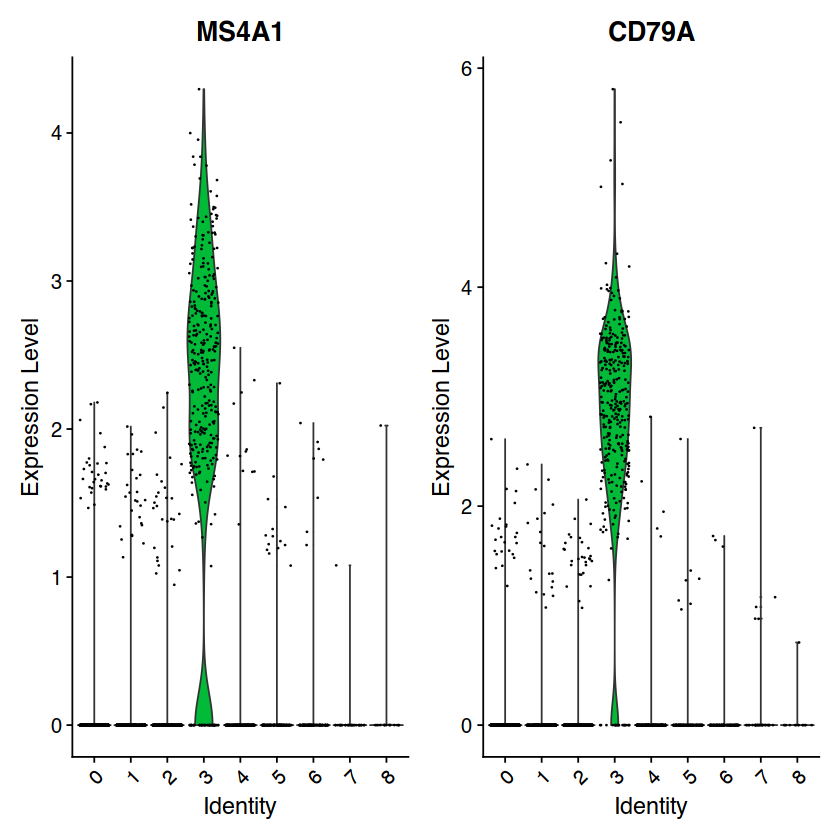

In [40]:
# We include several tools for visualizing marker expression
# VlnPlot() (shows expression probability distributions across clusters), and FeaturePlot() (visualizes feature expression on a tSNE or PCA plot) are our most commonly used visualizations
# We also suggest exploring RidgePlot(), CellScatter(), and DotPlot() as additional methods to view your dataset.

VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

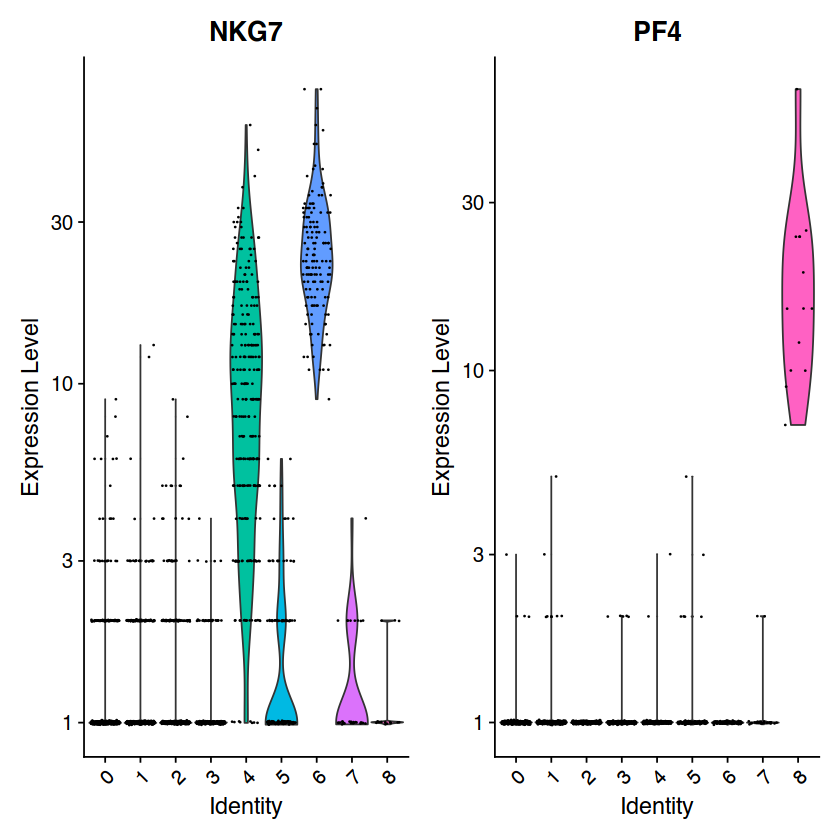

In [43]:
# you can plot raw counts as well rather than probability distributions
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

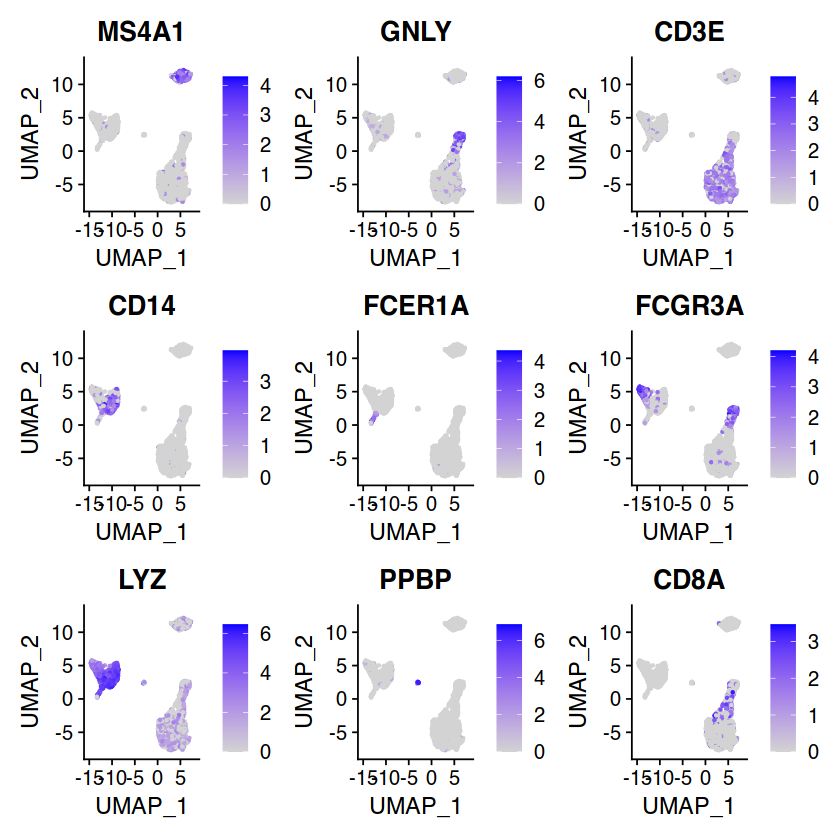

In [44]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

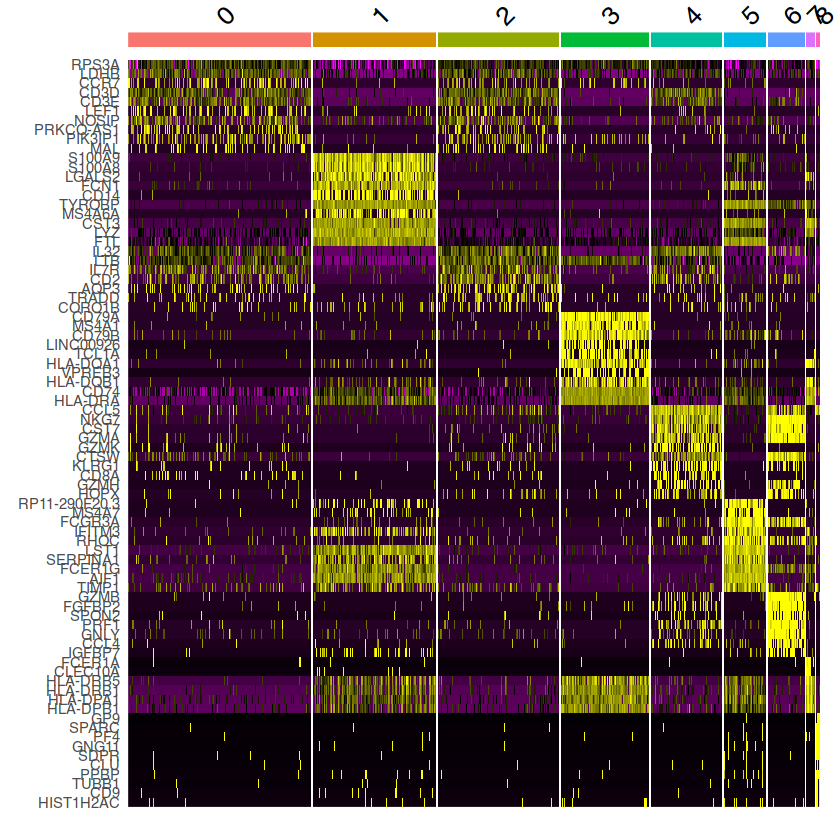

In [45]:
# DoHeatmap() generates an expression heatmap for given cells and features
# In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

In [48]:
# Step 11: Assigning cell type identity to clusters

# known markers for this dataset...
# Cluster ID	Markers	        Cell Type
# 0	            IL7R, CCR7	    Naive CD4+ T
# 1	            CD14, LYZ	    CD14+ Mono
# 2	            IL7R, S100A4	Memory CD4+
# 3	            MS4A1	        B
# 4	            CD8A	        CD8+ T
# 5	            FCGR3A, MS4A7	FCGR3A+ Mono
# 6	            GNLY, NKG7	    NK
# 7	            FCER1A, CST3	DC
# 8	            PPBP	        Platelet

new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()
saveRDS(pbmc, file = "../output/pbmc3k_final.rds")